# Implementing cluster validity index

In [ ]:
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd

from scipy.spatial.distance import cdist, pdist
from sklearn.neighbors import KDTree
import itertools

## Datasets
from sklearn.datasets import make_blobs, make_moons

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Índices implementados

## Base class

In [ ]:
class ClusterValIndex():
  def __init__(self):
    pass

  def score(self, X, y):
    self._X = X.copy()
    self._y = y.copy()
    self._calculate_no_clusters()

  def _calculate_no_clusters(self):
    self._n_clusters = len( np.unique(self._y) )

  def _y_cluster_ind(self, cluster):
    return np.argwhere(self._y == cluster)

  def _points_of_cluster(self, cluster):
    return self._X[self._y_cluster_ind(cluster)].squeeze()

## Silhouette score (?)

## Dunn index

<big>
$\displaystyle V_D = \frac{ \underset{ 0<i,j<K, i\neq j }{\min} \left\{ 
  \delta(C_i, C_j)  \right\} }{ \underset{ 0<k<K  }{\max} \left\{ \Delta(C_k)\right\} } $
</big>


Pontos negativos
- Somente clusters globulares
- Todos os pontos precisam estar agrupados
- Variância infinita (?)

In [ ]:
class DunnIndex( ClusterValIndex ):
  def __init__(self, metric='euclidean'):
    super(DunnIndex, self).__init__()
    self._metric = metric
  
  def score(self, X, y):
    super().score(X, y)
    min_cluster_distance = np.inf
    max_cluster_diameter = 0

    for cluster_0, cluster_1 in itertools.product( range(self._n_clusters), repeat=2 ):
      # Avoid redundant calcuations
      if cluster_0 < cluster_1:
        continue
      
      max_cluster_diameter = max( max_cluster_diameter, self._cluster_diameter(cluster_1) )

      if cluster_0 == cluster_1:
        continue
      min_cluster_distance = min(min_cluster_distance, 
                                 self._inter_cluster_distance(cluster_0, cluster_1) 
                                )
      
    score = min_cluster_distance/max_cluster_diameter
    return score

  def _cluster_diameter( self, cluster ):
    # Maximum distance between 2 points of a cluster
    diameter = np.max( pdist(self._points_of_cluster(cluster), 
                             metric=self._metric 
                             ) 
                     )
    return diameter

  def _inter_cluster_distance( self, cluster_0, cluster_1 ):
    # Minimum distance between 2 points of different clusters
    return np.min( cdist(self._points_of_cluster(cluster_0), 
                         self._points_of_cluster(cluster_1), 
                         metric=self._metric
                         ) 
                 )


## Generalized Dunn Index

In [ ]:
class GeneralizedDunnIndex( DunnIndex ):
  def __init__(self, *args, **kwargs):
    super(GeneralizedDunnIndex, self).__init__(*args)

  def _cluster_diameter( self, cluster ):
    # Maximum distance between 2 points of a cluster
    X_cluster = self._points_of_cluster(cluster)
    centroid = np.mean( X_cluster, axis=0 ).reshape( (1,-1) )
    diameter = 2*np.mean( cdist(X_cluster, centroid, metric=self._metric ) )
    return diameter

  def _inter_cluster_distance( self, cluster_0, cluster_1 ):
    # Minimum distance between 2 points of different clusters
    X_cluster_0 = self._points_of_cluster(cluster_0)
    X_cluster_1 = self._points_of_cluster(cluster_1)
    distances = cdist(X_cluster_0, X_cluster_1, metric=self._metric)
    distance = np.sum(distances)
    return distance/( 2*(len(X_cluster_0)*len(X_cluster_1) ) )

## Davies-Bouldin Index


Internal dispersion:

$\displaystyle S_{i, q}=\left(\frac{1}{\left|C_{i}\right|} \sum_{x \in C_{i}}\left|x-c_{i}\right|^{q}\right)^{1 / q}$

Distance between clusters (Minkowski):

$ d_{ij, t} = || z_i - z_j ||_t $

Similarity between clusters:

$R_{i j}=\underset{j, j \neq i}{\max}\left\{\frac{S_{i, q}+S_{j, q}}{d_{i j, t}}\right\}$

Final score:

$\displaystyle \frac{1}{c}\sum^{c}_{i=1} R_{i j} $




In [ ]:
class DaviesBouldinIndex( ClusterValIndex ):
  def __init__(self, metric='euclidean', q=1, p=2):
    super(DaviesBouldinIndex, self).__init__()
    self._q = q
    self._metric = metric
    self._p = p

  def score(self, X, y):
    super().score(X, y)

    self._calculate_clusters_internal_dispersions()
    self._intra_cluster_similarity_matrix = np.zeros( (self._n_clusters, self._n_clusters) )

    for cluster_0, cluster_1 in itertools.product( range(self._n_clusters), repeat=2 ):
      # Avoid redundant calcuations
      if cluster_0 == cluster_1:
        self._intra_cluster_similarity_matrix[cluster_1][cluster_0] = 0
        continue

      if cluster_0 > cluster_1:
        self._intra_cluster_similarity_matrix[cluster_0][cluster_1] = self._intra_cluster_similarity_matrix[cluster_1][cluster_0]
        continue
        
      self._intra_cluster_similarity_matrix[cluster_0][cluster_1] = self._intra_cluster_similarity(cluster_0, cluster_1)

    return -1*np.mean( np.max(self._intra_cluster_similarity_matrix, axis=1) )

  def _intra_cluster_similarity(self, cluster_0, cluster_1 ):
    dispersion_sum = self._cluster_dispersion[cluster_0] + self._cluster_dispersion[cluster_1]
    distance = self._inter_cluster_distance(cluster_0, cluster_1)
    return dispersion_sum/distance

  def _calculate_clusters_internal_dispersions(self):
    self._cluster_dispersion = [ self._cluster_internal_dispersion(k) for k in range(self._n_clusters) ]

  def _cluster_internal_dispersion(self, cluster):
    X_cluster = self._points_of_cluster(cluster)
    centroid = np.mean( X_cluster, axis=0 ).reshape( (1,-1) )
    dist_to_centroid = cdist(X_cluster, centroid, metric=self._metric ).flatten()
    dispersion = np.power( np.mean( dist_to_centroid**self._q ), 1.0/self._q )
    return dispersion

  def _inter_cluster_distance( self, cluster_0, cluster_1 ):
    X_cluster_0 = self._points_of_cluster(cluster_0)
    X_cluster_1 = self._points_of_cluster(cluster_1)
    centroid_0 = np.mean( X_cluster_0, axis=0 ).reshape( (1,-1) )
    centroid_1 = np.mean( X_cluster_1, axis=0 ).reshape( (1,-1) )

    distance = cdist(centroid_0, centroid_1, 'minkowski', p=self._p)[0,0]
    return distance

## Calinski-Harabasz Index

$\displaystyle V_{C H}=\frac{\frac{\sum_{k=1}^{K} n_{k}\left\|z_{k}-z\right\|^{2}}{(K-1)}}{\frac{\sum_{k=1}^{K} \sum_{i=l}^{n_{k}}\left\|x_{i}-z_{k}\right\|^{2}}{(n-K)}}=\frac{(n-K) \sum_{k=1}^{K} n_{k}\left\|z_{k}-z\right\|^{2}}{(K-1) \sum_{k=1}^{K} \sum_{i=1}^{n_{k}}\left\|x_{i}-z_{k}\right\|^{2}}$

In [ ]:
from scipy.spatial.distance import euclidean

In [ ]:
class CalinskiHarabaszIndex( ClusterValIndex ):
  def score(self, X, y):
    super().score(X, y)
    self._global_centroid()
    self._cluster_centroid = np.zeros( ( self._n_clusters, self._X.shape[1] ) )

    cluster_dispersion_sum = 0
    cluster_internal_dispersion_sum = 0 
    n_points_X = len(self._X)

    for cluster in range(self._n_clusters):
      cluster_dispersion_sum += self._cluster_global_dispersion(cluster)
      cluster_internal_dispersion_sum += self._cluster_internal_dispersion(cluster)

    index = cluster_dispersion_sum/cluster_internal_dispersion_sum
    index = (n_points_X-self._n_clusters)/(self._n_clusters - 1)*index

    return index

  def _global_centroid(self):
    self._global_centroid = np.mean( self._X, axis=0 ).reshape( (1,-1) )

  def _cluster_global_dispersion(self, cluster):
    X_cluster = self._points_of_cluster(cluster)
    self._cluster_centroid[cluster] = np.mean( X_cluster, axis=0 )
    return len(X_cluster)*( euclidean( self._cluster_centroid[cluster], self._global_centroid )**2 )

  def _cluster_internal_dispersion(self, cluster):
    X_cluster = self._points_of_cluster(cluster)
    centroid = self._cluster_centroid[cluster].reshape( (1,-1) )
    dist_to_centroid = cdist(X_cluster, centroid, metric='euclidean' ).flatten()**2
    dispersion = np.sum( dist_to_centroid )
    return dispersion
  

## CDbw (?)

In [ ]:
class CDbw( ClusterValIndex ):
  def __init__(self, n_representants=10):
    super(CDbw, self).__init__()
    self._n_representants = n_representants

  def score(self, X, y):
    super().score(X, y)
    self._mean_cluster_std()
    self._cluster_representants = np.zeros( (self._n_clusters, self._n_representants, self._X.shape[1]) )
    
    for cluster in range(self._n_clusters):
      self._infer_cluster_representants(cluster)

    # Intra cluster density
    mean_intra_cluster_density = np.mean( [
                                           self._intra_cluster_density(cluster) 
                                           for cluster in range(self._n_clusters)
                                          ] 
                                        )
    mean_intra_cluster_density = mean_intra_cluster_density/self._mean_std

    # Inter cluster density
    inter_cluster_density = np.sum( [
                                     self._inter_cluster_density( cluster_0, cluster_1 )
                                     for cluster_0, cluster_1 in itertools.product( range(self._n_clusters), repeat=2 )
                                     if cluster_0 > cluster_1
                                    ] 
                                  )

    # Separation
    separation = np.sum( [
                          self._inter_cluster_distance( cluster_0, cluster_1 )
                          for cluster_0, cluster_1 in itertools.product( range(self._n_clusters), repeat=2 )
                          if cluster_0 > cluster_1
                         ] 
                       )
    separation = separation/(inter_cluster_density+1)

    index = separation*mean_intra_cluster_density
    return index
    

  def _infer_cluster_representants(self, cluster):
    X_cluster = self._points_of_cluster(cluster).copy()

    centroid = np.mean( X_cluster, axis=0 ).reshape( (1,-1) )
    pivot = centroid.copy()
    for i in range( self._n_representants ):
      # Retrieve the farthest point from the actual pivot
      point_id = np.argmax( cdist(X_cluster, pivot, metric='euclidean') )

      self._cluster_representants[cluster, i, :] = X_cluster[point_id, :]
      pivot = X_cluster[point_id, :].reshape( (1,-1) )
      X_cluster[point_id, :] = centroid

  def _mean_cluster_std(self):
    self._cluster_std = [np.std(self._points_of_cluster(cluster)) for cluster in range(self._n_clusters)]
    self._mean_std = np.mean( self._cluster_std )
    
  def _intra_cluster_density(self, cluster):
    X_cluster = self._points_of_cluster(cluster)
    density = 0

    for i in range( self._n_representants ):
      representant_vector = self._cluster_representants[cluster, i, :]
      representant_vector = representant_vector.reshape( (1, -1) )
      
      representant_density = (cdist(X_cluster, representant_vector, metric='euclidean')<=self._mean_std).sum()
      density += representant_density/self._n_representants

    return density


  def _inter_cluster_density(self, cluster_0, cluster_1):
    cluster_0_representants=self._cluster_representants[cluster_0, :, :]
    cluster_1_representants=self._cluster_representants[cluster_1, :, :]

    # Closest representants
    ids = np.unravel_index(
                           np.argmin(
                                     cdist(cluster_0_representants, cluster_1_representants), 
                                     axis=None
                                    ), 
                           (self._n_representants, self._n_representants) 
                          )
    representant_0 = cluster_0_representants[ ids[0] ]
    representant_1 = cluster_1_representants[ ids[1] ]

    mean_point = ((representant_0+representant_1)/2).reshape( (1, -1) )
    mean_std = ( self._cluster_std[cluster_0]+self._cluster_std[cluster_1] )/2
    cluster_distance = np.linalg.norm(representant_0-representant_1)

    # Points of both clusters
    X_clusters = np.concatenate( [self._points_of_cluster(cluster_0), 
                                  self._points_of_cluster(cluster_1)] 
                               )

    density = (cdist(X_clusters, mean_point, metric='euclidean')<=mean_std).sum()
    inter_density = density*cluster_distance/(2*mean_std)

    return inter_density

  def _inter_cluster_distance(self, cluster_0, cluster_1):
    cluster_0_representants=self._cluster_representants[cluster_0, :, :]
    cluster_1_representants=self._cluster_representants[cluster_1, :, :]

    # Closest representants
    ids = np.unravel_index(
                           np.argmin(
                                     cdist(cluster_0_representants, cluster_1_representants), 
                                     axis=None
                                    ), 
                           (self._n_representants, self._n_representants) 
                          )
    representant_0 = cluster_0_representants[ ids[0], : ]
    representant_1 = cluster_1_representants[ ids[1], : ]

    return np.linalg.norm(representant_0-representant_1)

# Testing

## Datasets

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
def clustering_report( X, y ):
   return f"""
   Silhouette - {silhouette_score(X,y):.2f}
   Dunn - {DunnIndex().score( X,y ):.2f}
   G. Dun  - {GeneralizedDunnIndex().score( X,y ):.2f}
   Davies-Bouldin - {DaviesBouldinIndex().score( X,y ):.2f}
   Calinski Harabasz - {CalinskiHarabaszIndex().score( X,y ):.2f}
   CDbw - {CDbw().score( X,y ):.2f}
   """

def clustering_report_dict( X, y ):
   return {"Silhouette":silhouette_score(X,y),
           "Dunn":DunnIndex().score( X,y ),
           "G. Dun":GeneralizedDunnIndex().score( X,y ),
           "Davies-Bouldin":DaviesBouldinIndex().score( X,y ),
           "Calinski Harabasz":CalinskiHarabaszIndex().score( X,y ),
           "CDbw":CDbw().score( X,y )
          }

### **Blobs**

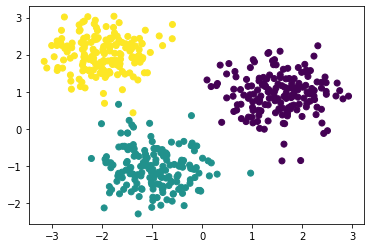

In [ ]:
X_blobs, y_blobs = make_blobs(n_samples=500, 
                              centers=[[1.5, 1], 
                                       [-1, -1],
                                       [-2, 2]
                                      ], 
                              cluster_std=0.5
                              )

plt.scatter( X_blobs[:,0], X_blobs[:,1], c=y_blobs )

**Evaluating KMeans**

In [ ]:
kmeans_models = [ KMeans(i) for i in range(2,9+1,1) ]
kmeans_results = dict()

for model in kmeans_models:
  y = model.fit_predict(X_blobs)
  kmeans_results[ model.n_clusters ] = clustering_report_dict( X_blobs, y )

Text(0.5, 1.0, 'Normalized Scores vs No. Clusters\n KMeans')

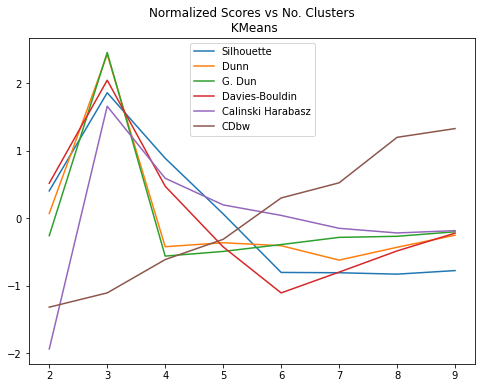

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )
kmeans_results_df = pd.DataFrame(kmeans_results).T
( (kmeans_results_df-kmeans_results_df.mean() )/kmeans_results_df.std()).plot(ax=ax)

ax.set_title("Normalized Scores vs No. Clusters\n KMeans")

Random Labels

In [ ]:
dummy_results = dict()

for i in range(2, 30):
  y = np.random.randint(0, i, len(X_blobs))
  dummy_results[i] = clustering_report_dict( X_blobs, y )

Text(0.5, 1.0, 'Normalized Scores vs No. Clusters\n Random')

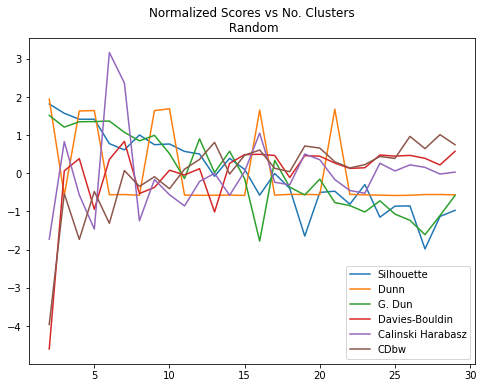

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )
dummy_results_df = pd.DataFrame(dummy_results).T
( (dummy_results_df-dummy_results_df.mean() )/dummy_results_df.std()).plot(ax=ax)

ax.set_title("Normalized Scores vs No. Clusters\n Random")

### **Moons, Blobs and Noise**

In [ ]:
from sklearn.cluster import KMeans
import hdbscan
!pip install hdbscan

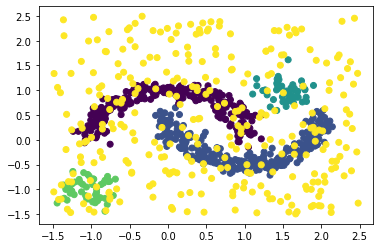

In [ ]:
np.random.seed(214)

X_moons, y_moons = make_moons( n_samples=500, noise=0.1 )
X_2blobs, y_2blobs = make_blobs( n_samples=100, centers=[ [1.5,1], [-1, -1] ], cluster_std=0.2 )
y_2blobs += 2

X_noise = np.array( [ np.random.uniform(-1.5, 2.5, 300 ), np.random.uniform(-1.5, 2.5, 300 ) ] ).T
y_noise = 4+np.zeros(300)

X_mbs = np.concatenate( [X_moons, X_2blobs, X_noise] )
y_mbs = np.concatenate( [y_moons, y_2blobs, y_noise] )

plt.scatter( X_mbs[:,0], X_mbs[:,1], c=y_mbs )

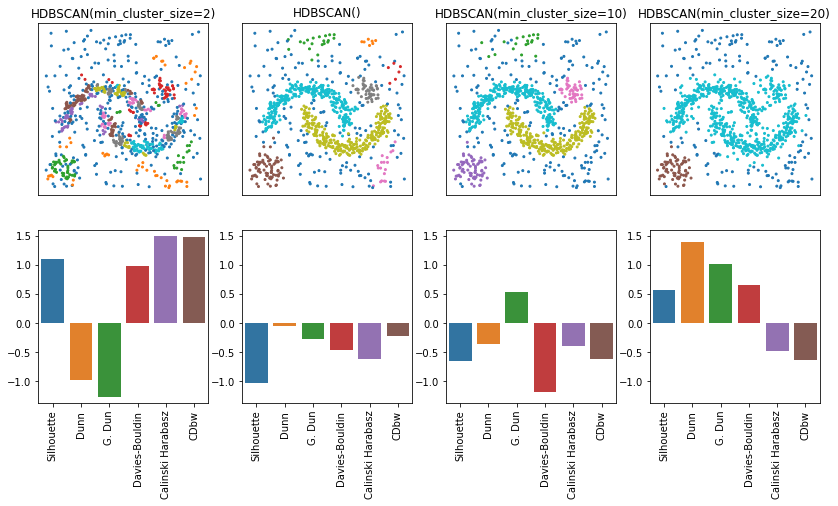

In [ ]:
hdbscan_models = [ hdbscan.HDBSCAN( min_cluster_size=min_cluster_size ) 
                   for min_cluster_size in [2, 5, 10, 20]
                 ]

fig, axs = plt.subplots( nrows=2, ncols=len(hdbscan_models), figsize=(14,7) )
axs = axs.T

hdbscan_results = dict()
for i, model in enumerate( hdbscan_models ):
  y = model.fit_predict(X_mbs)

  axs[i,0].scatter( X_mbs[:,0], X_mbs[:,1], c=y, s=4, cmap='tab10' )
  axs[i,0].set_xticks( [] )
  axs[i,0].set_yticks( [] )
  axs[i,0].set_title( str(model) )

  valid_X = X_mbs[ np.argwhere( y!=-1 ) ].squeeze()
  valid_y = y[ np.argwhere( y!=-1 ) ].squeeze()
  hdbscan_results[ str(model) ] = data=clustering_report_dict(valid_X, valid_y)

hdbscan_results_df = pd.DataFrame( hdbscan_results ).T
hdbscan_results_df = ( (hdbscan_results_df-hdbscan_results_df.mean())/hdbscan_results_df.std() )
min_y = hdbscan_results_df.to_numpy().min()
max_y = hdbscan_results_df.to_numpy().max()

for i, model in enumerate( hdbscan_models ):
  sns.barplot( data=hdbscan_results_df.loc[ [str(model)] ], ax=axs[i,1] )
  plt.setp( axs[i,1].xaxis.get_majorticklabels(), rotation=90 )
  axs[i,1].set_ylim( (min_y-0.1, max_y+0.1) )